# Business Problem

The Tanzania Development Trust is a UK charitable organization operating within the country of Tanzania since 1975.

They focus on development in rural Tanzania, aiming to support small projects in the poorest parts of the country where one of their priority areas of funding is clean water. Their stated water project involves boreholing and rope pump installation in areas with limited access to clean water, currently located in the regions of Kagera and Kigoma in the northwest of the country.

A new benefactor wants to expand the project not only geographically to more of the country, but in the scope of repairing existing pumps before they fail. I have been tasked with developing a model to predict the operating condition of a current waterpoint: functional, needs repair, or non-functional.

The main objective is to identify waterpoints that are in need of repair. [Research shows](https://sswm.info/entrepreneurship-resource/developing-impactful-businesses/maintenance-services-for-rural-water-pumps) that it is much less expensive to repair and rehabilitate a waterpoint, as well as being more protective of the water resources in the country. 
The secondary objective is to identify concentrations of non-functioning water points that may be an eligible location for a new installation.
______________________
The data provided for modeling was collected between March 2011 and March 2013, and contains the information for 59,400 water points 

# Imports

In [1]:
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
# import training data and target
raw_data = pd.read_csv('data/training_data.csv')
raw_target = pd.read_csv('data/training_target.csv')

display(raw_target.info())
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Create a raw dataframe with merged data and target. We will use this df during initial EDA so we can compare feature relationships with target, and so we can understand and deal with null values

In [3]:
raw_df = pd.merge(raw_data, raw_target, on='id')

The dataset for training includes 59,400 entries with 39 total features, a unique identifier, and a target label.

In [4]:
status_values = pd.DataFrame(raw_df.status_group.value_counts())
status_values['percent'] = round(raw_df.status_group.value_counts(normalize=True) * 100, 1)
status_values

,status_group,percent
functional,32259,54.3
non functional,22824,38.4
functional needs repair,4317,7.3


This is a ternary classification problem. The three possible values are:
- functional (F)
- non functional (NF)
- functional needs repair (FR)

Value counts show that our dataset is not balanced with respect to the label values. Only 7.3% of pumps are classified as functional needs repair, while 54.3% are functional and 38.4% are non functional. We will need to keep this imbalance in mind when modeling.
_________
Before any modeling can occur we must check and deal with null values


# Null Checks

In [5]:
null_checks = pd.DataFrame(data=raw_df.isna().sum(),
                          columns=['null_count'])
null_checks['percent_of_data'] = round((null_checks.null_count / len(raw_data)) * 100, 1)
null_checks = null_checks[null_checks.percent_of_data > 0.1]
null_checks.sort_values('percent_of_data', ascending=False, inplace=True)
null_checks

,null_count,percent_of_data
scheme_name,28166,47.4
scheme_management,3877,6.5
installer,3655,6.2
funder,3635,6.1
public_meeting,3334,5.6
permit,3056,5.1
subvillage,371,0.6


There are 7 features with null values in our dataset, and we can what that number of nulls is by percent of total available data. 
______
All of the features that contain null values are object types and will need to be converted. Before conversion we will need to address the null values.

## subvillage

In [6]:
subvillage_nans = raw_df[raw_df.subvillage.isnull()]
round(subvillage_nans.status_group.value_counts(normalize=True) * 100, 2)

functional                 55.26
non functional             44.47
functional needs repair     0.27
Name: status_group, dtype: float64

The null values in subvillage represent 0.6% of our total data. The distribution of the target label is close to the whole dataset

In [7]:
subvillage_nans.region.value_counts()

Dodoma    361
Mwanza     10
Name: region, dtype: int64

All but 10 of our subvillage nan's come from the region of Dodoma, the rest from Mwanza. Lets look at the subvillage distribution of those regions from the whole dataset

In [8]:
raw_df[raw_df['region'] == 'Dodoma'].subvillage.value_counts()

Kawawa         54
Shuleni        43
Nyerere        35
Azimio         34
Majengo        32
               ..
Foye            1
Mtatangwe       1
Makao Mapya     1
Soya Mjini      1
Mgomwa          1
Name: subvillage, Length: 705, dtype: int64

In [9]:
raw_df[raw_df['region'] == 'Mwanza'].subvillage.value_counts()

1                     132
Madukani               52
Bujingwa               25
Shuleni                19
Matale                 18
                     ... 
Bukalo                  1
Nyambona                1
Kabaganda B             1
Bulyahilu Center B      1
Mwambogwa               1
Name: subvillage, Length: 1507, dtype: int64

There are no average or overwhelmingly dominant subvillages that we could assign the null values to. It's not clear if we will use subvillage in modeling, so we will change null values to 'Other'

In [10]:
raw_df['subvillage'].fillna(value='Other', inplace=True)

## permit

In [11]:
permit_nans = raw_df[raw_df.permit.isnull()]
permit_nans.reset_index(drop=True, inplace=True)
round(permit_nans.status_group.value_counts(normalize=True) * 100, 2)

functional                 54.74
non functional             35.44
functional needs repair     9.82
Name: status_group, dtype: float64

5% of our dataset have no value for permit. Distribution of the target label is approximately the same as the whole dataset.

In [12]:
permit_distribution = raw_df.permit.value_counts(normalize=True)
permit_distribution

True     0.68955
False    0.31045
Name: permit, dtype: float64

Per the data documentation, the permit feature is if the water point is permitted or not. Data we do have for this feature show it's about 70/30 in favor of permitted.

We will randomly fill these 3056 missing datapoints with true/false in the same ratio we found in our entire dataset.

In [13]:
raw_df['permit'] = raw_df['permit'].fillna(pd.Series(np.random.choice([True, False],
                                                       p=list(permit_distribution),
                                                       size=len(raw_df))))

## public_meeting

In [14]:
public_meeting_nans = raw_df[raw_df.public_meeting.isnull()]
public_meeting_nans.reset_index(drop=True, inplace=True)
round(public_meeting_nans.status_group.value_counts(normalize=True) * 100, 2)

functional                 50.33
non functional             44.99
functional needs repair     4.68
Name: status_group, dtype: float64

5.6% of our dataset has no value for public_meeting. Distribution of the target label is approximately the same as the whole dataset.

In [15]:
meeting_distribution = raw_df.public_meeting.value_counts(normalize=True)
meeting_distribution

True     0.909838
False    0.090162
Name: public_meeting, dtype: float64

The public meeting feature is a boolean that is over 90% true for data we do have. We will fill null values in the same percentages.

In [16]:
raw_df['public_meeting'] = raw_df['public_meeting'].fillna(
    pd.Series(np.random.choice([True, False],
                               p=list(meeting_distribution),
                               size=len(raw_df))))

## funder & installer

The features 'funder' and 'installer' have almost the same number of null values; I am curious about the overlap of nulls.

In [17]:
# dividing the number of entries with null for both features by the smaller count
len(raw_df[raw_df.funder.isnull() & raw_df.installer.isnull()]) / null_checks.null_count['funder']

0.9854195323246218

Over 98% of the null values for funder also contain null values for installer.
________

In [18]:
funder_df = pd.DataFrame(round(raw_df.funder.value_counts(normalize=True, dropna=False) * 100, 2))
funder_df

,funder
Government Of Tanzania,15.29
NaN,6.12
Danida,5.24
Hesawa,3.71
Rwssp,2.31
...,...
Rarymond Ekura,0.00
Justine Marwa,0.00
Municipal Council,0.00
Afdp,0.00


In [19]:
funder_df_top = funder_df[funder_df.funder > 1.0]
print(f"Funders with more than 1% share: {len(funder_df_top)}")
print(f"Percent of total funders represented by above: {funder_df_top.sum()}")

Funders with more than 1% share: 18
Percent of total funders represented by above: funder    52.69
dtype: float64


Including null values, there were 1,898 distinct values for funder. Of that, 18 values (including null) have representative counts more than 1% of total data.

Those 18 distinct values represent almost 53% of our total data. We will convert null values to 'Other'. There are still lots of unique values, so something to consider is converting all funders with less than 1% total share as 'Other' to reduce the unique value count.

In [20]:
installer_df = pd.DataFrame(round(raw_df.installer.value_counts(normalize=True, dropna=False) * 100, 2))
installer_df

,installer
DWE,29.30
NaN,6.15
Government,3.07
RWE,2.03
Commu,1.78
...,...
Wizara ya maji,0.00
TWESS,0.00
Nasan workers,0.00
R,0.00


In [21]:
installer_df_top = installer_df[installer_df.installer > 1.0]
print(f"Installers with more than 1% share: {len(installer_df_top)}")
print(f"Percent of total installers represented by above: {installer_df_top.sum()}")

Installers with more than 1% share: 12
Percent of total installers represented by above: installer    51.6
dtype: float64


Similarly to funder, the installer feature is dominated by small share installers. Of the 2,146 distinct values for installer, 12 values (including null) have representative counts more than 1% of total data.

Those 12 distinct values represent almost 52% of our total data. This is similar to the funder feature. We will also convert null values to 'Other', and will consider converting all installers with less than 1% total share of installer as 'Other' to reduce the unique value count. 

In [22]:
raw_df['funder'].fillna(value='Other', inplace=True)
raw_df['installer'].fillna(value='Other', inplace=True)

## scheme_management

In [23]:
scheme_management_nans = raw_df[raw_df.scheme_management.isnull()]
scheme_management_nans.reset_index(drop=True, inplace=True)
round(scheme_management_nans.status_group.value_counts(normalize=True) * 100, 2)

functional                 48.31
non functional             45.94
functional needs repair     5.75
Name: status_group, dtype: float64

In [24]:
raw_df.scheme_management.value_counts(normalize=True, dropna=False)

VWC                 0.619411
WUG                 0.087643
NaN                 0.065269
Water authority     0.053081
WUA                 0.048535
Water Board         0.046263
Parastatal          0.028283
Private operator    0.017896
Company             0.017862
Other               0.012896
SWC                 0.001633
Trust               0.001212
None                0.000017
Name: scheme_management, dtype: float64

6.5% of our data has no value for scheme_management. Distribution of the target data is approximately the same as the whole dataset.
_________
There was only one entry with the value of 'None', we will change that to 'Other'

In [25]:
raw_df.at[23603, 'scheme_management'] = 'Other'

We will fill null values for scheme_management randomly with other values from the feature in the same percentage.

In [26]:
scheme_management_list = pd.DataFrame(raw_df.scheme_management.value_counts(normalize=True))
scheme_management_list

,scheme_management
VWC,0.662662
WUG,0.093763
Water authority,0.056787
WUA,0.051924
Water Board,0.049493
Parastatal,0.030258
Private operator,0.019145
Company,0.019109
Other,0.013814
SWC,0.001747


In [27]:
raw_df['scheme_management'] = raw_df['scheme_management'].fillna(
    pd.Series(np.random.choice(list(scheme_management_list.index),
                               p=list(scheme_management_list.scheme_management),
                               size=len(raw_df))))

## scheme_name

In [28]:
raw_df.scheme_name.value_counts(normalize=True, dropna=False)

NaN                        0.474175
K                          0.011481
None                       0.010842
Borehole                   0.009192
Chalinze wate              0.006818
                             ...   
Visiga water supplly       0.000017
Emanyata pipelines         0.000017
Magundi water supply       0.000017
Imalampaka water supply    0.000017
Mtawanya                   0.000017
Name: scheme_name, Length: 2697, dtype: float64

Almost half (47%) of the scheme_name feature contains no data, and the remaining data contains 2,697 distinct other features, none of which exceed 1% of the dataset. Lets look a little closer to see what else we can figure out.

In [29]:
scheme_name = pd.DataFrame(raw_df.scheme_name.value_counts(dropna=False))
scheme_name[scheme_name.scheme_name > 75]

,scheme_name
NaN,28166
K,682
None,644
Borehole,546
Chalinze wate,405
M,400
DANIDA,379
Government,320
Ngana water supplied scheme,270
wanging'ombe water supply s,261


The scheme name, per the documentation, is the individual or group that actually operates the waterpoint. This is compared to the scheme management company, which oversees operation. When the data was collected, it looks like there was little organization with respect to this particular datapoint. Considering the there are no other patterns in the available names, and that we have the management data, we will likely not use this feature in modeling.
_____
We will replace null values with 'None'

In [30]:
raw_df['scheme_name'].fillna(value='None', inplace=True)

# Exploring numerical data

Creating a dataframe of just the current numerical features as well as the target. Mapping numerical values to the target: 'non functional' = 0, 'functional needs repair' = 1, and 'functional' = 2.

In [31]:
num_df = pd.merge(raw_data.select_dtypes(include=np.number), raw_target, on='id')

status_dict = {'non functional': 0,
              'functional needs repair': 1,
              'functional': 2}

num_df['target'] = num_df['status_group'].map(lambda x: status_dict[x])
num_df.drop('status_group', axis=1, inplace=True)
num_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,1.158838
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


The 'id' feature is a unique identifier, we will leave it in for merge purposes later but will not use it in modeling so no investigation needed.

The 'amount_tsh' feature is the total amount of water available to the waterpoint. It looks like at least 50% of our waterpoints do not have any water available, regardless of pump functionality. If we look back, we also see that over 50% of pumps are classified as functional. This is a bit concerning, it's unclear how you can have a functional pump with no water available to pump.

'gps_height' is concerning. [Research shows](https://en.wikipedia.org/wiki/Geography_of_Tanzania) that the lowest point in the country is sea level (0), yet we have a minimum of -90, so we will need to investigate that.

[Research shows](https://worldpopulationreview.com/countries/tanzania/location) that Tanzania's most extreme latitudes range from 00&deg;59'S (-0.98333) to 11&deg;45'S (-11.75), while the longitude extremes range from 40&deg;29'E (40.48333) to 29&deg;10'E (29.16667)

The 'latitude' values seem to exceed the northen border of the country (max latitude -2e-08), so we will need to investigate that. The 'longitude' values minimum is 0, so we have some data that is outside the range of the country borders. It's likely from mistakes or errors in data entry, but we need to investigate the extent and fix it.

There is no description of 'num_private' in the datasource, we'll have to look at that. It may not factor into modeling.

'region_code' and 'district_code' will need to be investigated separately as well, the documentation is not clear about what that data represents.

'construction_year' and 'population' each have minimums of 0, and that should definitely not be the case in construction year. It's possible a waterpoint exists in a place considered to have no population, but we'll need to investigate these further.

## amount_tsh

In [32]:
len(num_df[num_df.amount_tsh == 0.0]) / len(num_df)

0.700993265993266

70% of our datapoints list the amount_tsh as equal to 0.0. This can't mean that the waterpoint has no water available. We need to understand more about what total static head means. [Research shows](https://www.pumpfundamentals.com/tutorial2.htm#:~:text=If%20the%20liquid%20surface%20of,the%20friction%20in%20the%20system.) that a pump system's static head is the difference between the liquid surface of the reservoir and the discharge end of the pump system. The higher the discharge tube is lifted above the liquid surface, the harder is is for the pump to move the water, and the lower the flow rate will be. I would imagine that the requirements of pump location to discharge would impact the type of pump to be used.

In [33]:
num_df.groupby('target').mean()[['amount_tsh']]

,amount_tsh
target,
0,123.481230
1,267.071577
2,461.798235


In [34]:
num_df[num_df.amount_tsh > 0]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,2
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,2
5,9944,20.0,0,39.172796,-4.765587,0,4,8,1,2009,2
11,50409,200.0,1062,35.770258,-10.574175,0,10,5,250,1987,2
16,48451,500.0,1703,34.642439,-9.106185,0,11,4,35,1978,0
...,...,...,...,...,...,...,...,...,...,...,...
59385,34473,500.0,1327,33.951681,-2.021854,0,20,4,200,2011,2
59387,26640,100.0,25,39.176480,-6.957098,0,7,2,100,2000,2
59394,11164,500.0,351,37.634053,-6.124830,0,5,6,89,2007,0
59395,60739,10.0,1210,37.169807,-3.253847,0,3,5,125,1999,2


The average total static head increases with each pump status category, from 0 (non function) to 2 (functional). We will have to engineer this feature in some way in order to utilize it. Most of our values are 0, we have none that are below that, and the maximum value is 350,000 feet.

## gps_height

In [35]:
gps_height_neg = num_df[num_df.gps_height < 0]
print(f"Percent of total data: {round(len(gps_height_neg)/len(num_df)*100,2)}%")
gps_height_neg.describe()

Percent of total data: 2.52%


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,37297.606952,313.013369,-19.993316,39.352801,-7.727535,0.506684,34.703877,15.531417,258.137032,1686.096257,1.073529
std,21119.500129,4017.641868,12.154136,0.458811,1.542230,7.155227,35.259116,21.812220,428.417873,726.379806,0.983446
min,150.000000,0.000000,-90.000000,38.614960,-10.946096,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000
25%,19232.750000,0.000000,-28.000000,38.972421,-8.584131,0.000000,6.000000,1.000000,40.000000,1976.000000,0.000000
50%,36699.000000,0.000000,-18.000000,39.281546,-7.415977,0.000000,7.000000,5.000000,102.500000,2000.000000,2.000000
75%,55492.750000,50.000000,-11.000000,39.662349,-6.524902,0.000000,60.000000,13.000000,320.000000,2008.000000,2.000000
max,74211.000000,138000.000000,-1.000000,40.345193,-5.278598,150.000000,99.000000,67.000000,4520.000000,2013.000000,2.000000


There are 1,496 datapoints where the gps_height was less than 0, about 2.5% of our data. Earlier we mentioned that this should not be possible as the listed lowest elevation for Tanzania is 0 ft above sea level (at the Indian Ocean). [Research shows](https://eos-gnss.com/knowledge-base/articles/elevation-for-beginners) that most GPS units are designed to measure height based on the representation of the earth's surface as an 'ellipsoid', and it's perfectly possible to be standing at sea level where the reading should be 0 and have it be a negative number. 

Considering these data are almost all on the eastern edge of the country (lower longitudes) closer to the Indian Ocean, it is likely the sites are at or just above sea level and capable of producing negative height readings. Opportunity for further tuning could be to address this incosistency across all the data, shifting all datapoints to a more accurage representation of height. I do not think it would be as simple as shifting all values up by the largest negative difference. Because it's such a small percentage of our dataset, we will just set them to 0 rather than worry about adjusting all the values.

In [36]:
num_df.gps_height.clip(lower=0.0, inplace=True)

## longitude/latitude

The max longitude is within the boundaries, we need to examine all values below the actual minimum which is 29.16667.

In [37]:
longitude_errors = num_df[num_df.longitude < 29.16667]
longitude_errors.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,1812.000000,1812.0,1812.0,1812.0,1.812000e+03,1812.0,1812.000000,1812.000000,1812.0,1812.0,1812.000000
mean,37389.841060,0.0,0.0,0.0,-2.000000e-08,0.0,17.820088,2.497241,0.0,0.0,1.173289
std,21413.129962,0.0,0.0,0.0,3.309636e-24,0.0,1.023562,2.157389,0.0,0.0,0.870267
min,15.000000,0.0,0.0,0.0,-2.000000e-08,0.0,11.000000,1.000000,0.0,0.0,0.000000
25%,18481.750000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,0.000000
50%,37326.000000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,1.000000
75%,55509.750000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000
max,74193.000000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000


It looks like we have found that our data includes errors in GPS readings. These errors show up as longitude 0 and latitude -2e-0.8. These entries with GPS errors, however, do not account for all the population point values of 0, or the construction year values of 0, so we will still need to address them.

In [38]:
print(f"Percent of data with missing lat/long: {round((len(longitude_errors)/len(num_df))*100, 2)}%")

print(f"Total data with population of 0: {len(num_df[num_df.population == 0])}")
print(f"Total data with construction year of 0: {len(num_df[num_df.construction_year == 0])}")

Percent of data with missing lat/long: 3.05%
Total data with population of 0: 21381
Total data with construction year of 0: 20709


In [39]:
gps_errors = raw_df[raw_df.longitude == 0.0]
gps_errors.status_group.value_counts(normalize=True)

functional                 0.480132
non functional             0.306843
functional needs repair    0.213024
Name: status_group, dtype: float64

In [40]:
gps_errors.region_code.value_counts()

17    1057
19     752
11       3
Name: region_code, dtype: int64

The missing GPS data comprises about 3% of our dataset, but contains a disproportionate number of the 'functional needs repair' value from the target, which we already have very little data for. Also, all of the missing GPS data comes from three regions: 11, 17, and 19. 

What we can do is take the average lat/long from the points we do have for those region_codes and fill our nulls with the average for that region_code with a little randomness added in.

In [41]:
# get the list of the region codes with errors
error_regions = list(gps_errors.region_code.value_counts().index)

for region in error_regions:
    # split the data based on longitude not being 0.0
    region_no_gps = num_df[(num_df.region_code == region) & (num_df.longitude == 0.0)]
    region_gps_data = num_df[(num_df.region_code == region) & (num_df.longitude != 0.0)]
    # get mean and std for the long/lat of gps data we have
    avg_long = region_gps_data[['longitude', 'latitude']].mean()[0]
    avg_lat = region_gps_data[['longitude', 'latitude']].mean()[1]
    long_std = region_gps_data[['longitude', 'latitude']].std()[0]
    lat_std = region_gps_data[['longitude', 'latitude']].std()[1]
    # initialize empty lists for random data to fill
    fill_long = []
    fill_lat = []
    # append to each list a random value within the standard deviation of the mean
    for x in range(len(region_no_gps)):
        fill_long.append(random.triangular(avg_long+long_std, avg_long-long_std))
        fill_lat.append(random.triangular(avg_lat+lat_std, avg_lat-lat_std))
        x += 1
    # convert the two lists into a dataframe
    fill_df = pd.DataFrame([fill_long, fill_lat]).transpose()
    fill_df.columns = ['longitude', 'latitude']
    # replace the missing GPS data with these randomized values
    num_df.loc[region_no_gps.index, ['longitude', 'latitude']] = fill_df

## num_private

In [42]:
num_df.num_private.value_counts(normalize=True)

0       0.987256
6       0.001364
1       0.001229
5       0.000774
8       0.000774
          ...   
42      0.000017
23      0.000017
136     0.000017
698     0.000017
1402    0.000017
Name: num_private, Length: 65, dtype: float64

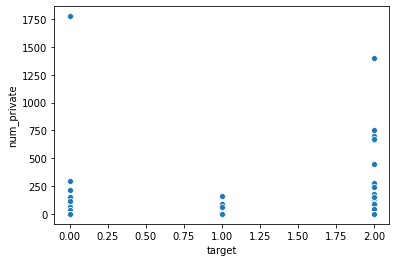

In [108]:
sns.scatterplot(data=num_df, x='target', y='num_private');

The vast majority of the num_private data has the value 0. There was no descriptor of the feature along with the others for the dataset, so we have no way to reference the value. 98% of the values in this feature are '0'. After looking at a quick scatterplot, we conclude it's very unlikely that there would be any statistically significant relationship between this feature and the target. We are going to drop it from num_df

In [109]:
num_df.drop('num_private', axis=1, inplace=True)

## region_code

What we suspect is that the regions are the parent in the relationship with district, and that each region has multiple districts in them. Since we have codes for region and strings for regions, lets compare them and see what we can discover.

In [54]:
print(f"Region numeric unique value count: {len(num_df.region_code.value_counts())}")
print(f"Region string unique value count: {len(raw_df.region.value_counts())}")
print("------------------------------------")
region_code_vals = list(map(str, list(num_df.region_code.value_counts().sort_index().index)))
print("Region_code values:")
print(", ".join(region_code_vals))
print("------------------------------------")
high_region_codes = raw_df[(num_df.region_code > 21)].copy()
print(f"Entries with region code > 21: {len(high_region_codes)}")
print(f"Percent of total data: {round(len(high_region_codes)/len(raw_df)*100, 2)}%")
print("------------------------------------")

Region numeric unique value count: 27
Region string unique value count: 21
------------------------------------
Region_code values:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 40, 60, 80, 90, 99
------------------------------------
Entries with region code > 21: 3930
Percent of total data: 6.62%
------------------------------------


In [44]:
len(raw_df[(raw_df.region_code > 21)]) == len(raw_df[(raw_df.region_code > 21) & (raw_df.longitude != 0.0)])

True

We can see that the values of region_code go from 1 to 21, and then we have values 24, 40, 60, 80, 90, 99. It's likely that the values 1-21 match up to the 21 string value regions in the feature 'region'.

Entries with region_code values above 21 constitute 6.6% of our dataset, and all of the data categorized in these other region_codes contain correct lat/long data. (note: checked this using the raw_df, not the num_df we modified the missing lat/longs for)

As for the others, they serve some kind of purpose inputting data. We will need to figure out:
- What region_code matches to what region?
- What do the >21 region_code values mean?
_________
We are going to create a dataframe that goes through the region_codes 1-21 and adds the top reporting region/count from the value_count for that particular region_code. Then we look at any differences between those counts and the raw counts of entries with each region code.

In [45]:
region_code_list = []

for x in range(1, 22):
    region = raw_df[raw_df.region_code == x]['region'].value_counts().index[0]
    count = raw_df[raw_df.region_code == x]['region'].value_counts().values[0]
    region_code_list.append((x, region, count))
    
region_df = pd.DataFrame(region_code_list, columns=['region_code', 'region', 'region_count'])
region_df['region_code_count'] = raw_df.region_code.value_counts().sort_index().values[:21]

region_df['surplus_code_count'] = region_df['region_code_count'] - region_df['region_count']
region_df[region_df.surplus_code_count > 0]

,region_code,region,region_count,region_code_count,surplus_code_count
4,5,Morogoro,4006,4040,34
10,11,Iringa,5294,5300,6
13,14,Tabora,1959,1979,20
16,17,Shinyanga,4956,5011,55
17,18,Kagera,3316,3324,8


Of the 21 regions, 16 of them match up the region with a region_code and both features have the same count of values. There are 5 regions where the region_code value count has a surplus of values compared to the region value count.

For these few number of values, one thought is to update records for these region_codes so that all region_code values match to one region, i.e. we will update all rows where region_code is 5 so that the region 'Morogoro' is reflected. Just to be sure, lets look closer at this example.


In [46]:
raw_df[raw_df.region_code == 5].region.value_counts()

Morogoro    4006
Tanga         34
Name: region, dtype: int64

In [47]:
raw_df[(raw_df.region_code == 5) & (raw_df.region == 'Tanga')][['longitude', 'latitude']].describe()

,longitude,latitude
count,34.000000,34.000000
mean,37.180390,-6.039227
std,0.029752,0.025528
min,37.108257,-6.093574
25%,37.163602,-6.054215
50%,37.186427,-6.044506
75%,37.200669,-6.019999
max,37.231274,-5.992508


When we looked at the lat/long for the region_code 5 rows that have the region label 'Tanga', the most northern/eastern (min) value was within the boundary of the region 'Morogoro', but very close to the border. Tanga is the northern neighbor to region. We are going to make an assumption that these values of region_code reference the same region string, and assume that is also the case for the remaining surpluses. We will update those region values accordingly so that each region_code corresponds to one and only one region string. **Note: we are modifying the original raw_df here. We will then split off all categorical features in section 5 to encode. The 'region' feature is not a part of num_df**

In [48]:
fixes = list(zip(list(region_df[region_df.surplus_code_count > 0].region_code.values),
    list(region_df[region_df.surplus_code_count > 0].region.values)))

for fix in fixes:
    code = fix[0]
    region = fix[1]
    
    raw_df.loc[raw_df[(raw_df.region_code == code) & (raw_df.region != region)].index, 'region'] = region

Now we need to examine the region_codes whose value is over 21 and figure out what they mean.

In [59]:
num_df[num_df.region_code > 21].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000,3930.000000
mean,36925.385242,94.034606,294.397455,38.870664,-8.931247,0.158779,74.506616,34.425445,377.267684,1888.388295,0.877863
std,21289.776436,917.322899,397.755981,1.075679,2.118719,7.196633,19.924407,18.065889,776.105818,453.402238,0.966132
min,5.000000,0.000000,0.000000,35.293842,-11.366974,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000
25%,18643.250000,0.000000,30.000000,38.802982,-10.535635,0.000000,60.000000,23.000000,1.000000,1983.000000,0.000000
50%,37073.000000,0.000000,182.000000,39.095900,-9.907659,0.000000,80.000000,33.000000,200.000000,2002.000000,0.000000
75%,55454.000000,25.000000,358.000000,39.384740,-7.774284,0.000000,90.000000,53.000000,400.000000,2008.000000,2.000000
max,74211.000000,30000.000000,1861.000000,40.345193,-3.157267,450.000000,99.000000,67.000000,8000.000000,2013.000000,2.000000


There's too much variation in the lat/long to use these averages and assign region_codes. Lets look at them a bit closer to see what we can figure out.

In [57]:
num_df[num_df.region_code > 21].region_code.value_counts()

80    1238
60    1025
90     917
99     423
24     326
40       1
Name: region_code, dtype: int64

In [58]:
num_df[num_df.region_code == 40]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
31798,6200,0.0,34.0,39.217993,-7.001266,0,40,43,60,2010,0


Using google maps for this single point for region_code '40', we can see that it's definitely in the Pwani region, though close to the Dar es Salaam region border. Without any other values for that region_code, we would assume to just modify the value for region code. One thought is that maybe the Pwani region_code is 4, and someone hit an extra 0 when entering data.

We have modified our raw_df dataframe and assigned all region values based on the region_code value. Lets look at our data grouped by region value and see the average for the region_code. If the average is an integer, we know that all entries for that region is the same number as the entries for the region_code (that value being the mean of the region_code feature). If Pwani's region_code is 4, that is likely what happened with that entry.

In [69]:
raw_df.groupby('region')[['region_code']].mean().sort_values(by='region_code')

,region_code
region,
Dodoma,1.000000
Kilimanjaro,3.000000
Tanga,4.000000
Arusha,4.140896
Morogoro,5.000000
Dar es Salaam,7.000000
Ruvuma,10.000000
Iringa,11.000000
Mbeya,12.000000


We can see that the Pwani region does not have an integer region_code mean, so there are other region_codes represented in the region.

In [64]:
raw_df[raw_df.region == 'Pwani'][['region_code']].value_counts()

region_code
6              1609
60             1025
40                1
dtype: int64

All of the region_code '60' entries are marked with the region Pwani, in addition to the region_code '40'. Lets look at the region_code 60 and determine if both of them should change to region code 6 for Pwani.

In [72]:
raw_df[raw_df.region_code == 60][['longitude', 'latitude']].describe()

,longitude,latitude
count,1025.000000,1025.000000
mean,39.073593,-7.529581
std,0.334331,0.392400
min,38.236495,-8.477555
25%,38.857798,-7.883182
50%,39.067564,-7.622740
75%,39.281285,-7.112273
max,39.873861,-6.951109


There is very little variation in the lat/long for the entries with region_code 60. It's also maybe the case that our original suspicion of the code being entered with a trailing 0 may be on the nose after all, because Pwani's region_code is 6. When we consult google maps, it's most certainly the case that, even with the variation indicated by the standard deviation, region_codes 40 and 60 both actually should be 6.

In [74]:
num_df.loc[raw_df[raw_df.region_code.isin([40, 60])].index, 'region_code'] = 6

Next we'll check out region code 24.

In [80]:
raw_df[raw_df.region_code == 24].region.value_counts()

Arusha    326
Name: region, dtype: int64

In [81]:
raw_df[raw_df.region == 'Arusha'].region_code.value_counts()

2     3024
24     326
Name: region_code, dtype: int64

Unclear why, but maybe this is actually a case where a trailing digit was input incorrectly. Lets use the same approach and look at the average lat/long for those 326 entries in region_code 24.

In [82]:
raw_df[raw_df.region_code == 24][['longitude', 'latitude']].describe()

,longitude,latitude
count,326.000000,326.000000
mean,35.661985,-3.380886
std,0.161927,0.115230
min,35.293842,-3.669964
25%,35.605747,-3.495621
50%,35.671781,-3.355989
75%,35.790640,-3.285670
max,35.924154,-3.157267


Those values are solidly in the Arusha region. We will also reassign region_codes from 24 to 2.

In [83]:
num_df.loc[raw_df[raw_df.region_code == 24].index, 'region_code'] = 2

Next we will check out region_code 99

In [84]:
raw_df[raw_df.region_code == 99].region.value_counts()

Mtwara    423
Name: region, dtype: int64

In [85]:
raw_df[raw_df.region == 'Mtwara'].region_code.value_counts()

90    917
99    423
9     390
Name: region_code, dtype: int64

In [87]:
raw_df[raw_df.region_code.isin([90,99])][['longitude', 'latitude']].describe()

,longitude,latitude
count,1340.000000,1340.000000
mean,39.288805,-10.695680
std,0.562727,0.242950
min,38.013947,-11.366974
25%,38.932811,-10.870974
50%,39.168698,-10.695511
75%,39.826127,-10.518309
max,40.345193,-10.128340


We got lucky here, the average lat/long for all the entries in region_codes 90 and 99 are all solidly in the Mtwara region. So we can set them all to 9.

In [88]:
num_df.loc[raw_df[raw_df.region_code.isin([90, 99])].index, 'region_code'] = 9

Finally, the last one is region_code 80

In [89]:
raw_df[raw_df.region_code == 80].region.value_counts()

Lindi    1238
Name: region, dtype: int64

In [90]:
raw_df[raw_df.region == 'Lindi'].region_code.value_counts()

80    1238
8      300
Name: region_code, dtype: int64

In [92]:
raw_df[raw_df.region_code == 80][['longitude', 'latitude']].describe()

,longitude,latitude
count,1238.000000,1238.000000
mean,39.094711,-9.645071
std,0.495787,0.656522
min,37.404880,-10.565007
25%,38.930204,-10.148174
50%,39.172754,-9.910641
75%,39.462684,-9.164143
max,39.963363,-8.284239


The region_code 80 entries are all solidly in the Lindi region, so we will set them to 8.

In [93]:
num_df.loc[raw_df[raw_df.region_code == 80].index, 'region_code'] = 8

In [95]:
num_df.region_code.value_counts().sort_index()

1     2201
2     3350
3     4379
4     2513
5     4040
6     2635
7      805
8     1538
9     1730
10    2640
11    5300
12    4639
13    2093
14    1979
15    1808
16    2816
17    5011
18    3324
19    3047
20    1969
21    1583
Name: region_code, dtype: int64

We've got our 'region_code' feature all sorted out now and the values will match up uniquely with those in the 'region' feature.

## district_code

We have established that the regions in our dataset match up with the region_code; there is no 'district' dataset to match with 'district_code'. When researching Tanzanian regions we discovered information on quantity of districts  in each region, so we believe that is how our data relates: each region would have multiple districts in it. Lets look at value counts for district_code.

In [104]:
num_df.district_code.value_counts().sort_index()

0        23
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
13      391
23      293
30      995
33      874
43      505
53      745
60       63
62      109
63      195
67        6
80       12
Name: district_code, dtype: int64

Some initial observations:
- It seems odd to have districts with a value of 0.
- [Research shows](https://en.wikipedia.org/wiki/Regions_of_Tanzania) that there is one region with 10 districts (Tanga), but we don't have that value. 
- 10 is is also the largest value we should have for the feature, as that is the maximum number of districts for regions.

_____
If it is the case that district_code is representative of the actual district within the region, then each region should have at minimum a district_code of 1. The link above will also show that regions at a minimum have 2 districts (the average is about 5.5).

In [112]:
num_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,57617.000000,57617.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.800774,35.148683,-5.884251,10.851902,5.629747,179.909983,1300.652475,1.158838
std,21453.128371,2997.574558,692.620533,2.607149,2.809803,5.984537,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,0.000000,29.607122,-11.649440,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.283788,-8.642598,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,35.004338,-5.169334,11.000000,3.000000,25.000000,1986.000000,2.000000
75%,55656.500000,20.000000,1319.250000,37.233010,-3.372733,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-0.998464,21.000000,80.000000,30500.000000,2013.000000,2.000000


In [113]:
num_df[num_df.district_code == 1].region_code.value_counts().sort_index()

1      888
2      189
3      595
4      698
5     1128
6      984
7       93
9      423
10     423
11     728
12     298
13     544
14     574
15     679
16     874
17    1251
18     772
19     341
20     171
21     550
Name: region_code, dtype: int64

From this we can see that region 8 has no district_code value of 1. Lets look a little deeper.

In [114]:
num_df[num_df.region_code == 8].district_code.value_counts()

13    391
3     300
23    293
53    291
43    154
62    109
Name: district_code, dtype: int64

In [118]:
raw_df[num_df.region_code == 8]['region']

26       Lindi
91       Lindi
148      Lindi
159      Lindi
324      Lindi
         ...  
59201    Lindi
59251    Lindi
59254    Lindi
59297    Lindi
59383    Lindi
Name: region, Length: 1538, dtype: object

Region 8, Lindi, has 6 regions (per wikipedia link from above). There are 6 unique values for district_code for region 8, but do not seem to have any numbering order.
_________
Lets look at another region, region 1.

In [115]:
num_df[num_df.region_code == 1].district_code.value_counts()

1    888
3    361
5    358
4    347
6    224
0     23
Name: district_code, dtype: int64

In [117]:
raw_df[num_df.region_code == 1]['region']

30       Dodoma
37       Dodoma
89       Dodoma
114      Dodoma
242      Dodoma
          ...  
59279    Dodoma
59312    Dodoma
59335    Dodoma
59368    Dodoma
59398    Dodoma
Name: region, Length: 2201, dtype: object

Region 1 is Dodoma, which research shows should have 7 administrative districts. Just because we don't have 7 here doesn't mean that they are not accurate. The numbering is much more representative of what we would expect to see. If we started counting at 0, then we would have 7 values except missing values for district 3 (would be value 2 in data)
___________
Let's look at region 2 now to see if maybe it shows the same potential as region 1, or seems hopeless like region 8.

In [119]:
num_df[num_df.region_code == 2].district_code.value_counts()

2     1206
7     1009
30     326
6      310
5      201
1      189
3      109
Name: district_code, dtype: int64

In [120]:
raw_df[num_df.region_code == 2]['region']

35       Arusha
44       Arusha
57       Arusha
63       Arusha
77       Arusha
          ...  
59267    Arusha
59280    Arusha
59285    Arusha
59307    Arusha
59344    Arusha
Name: region, Length: 3350, dtype: object

District codes are a bit chaotic. Even the largest count value, district_code of 1, is not represented in all of our regions, which should be the case if each region had a separate count of districts. It's suspected that there will not be an easy way to reconcile this feature, and it will likely not be used in modeling. If we were able to organize this, we would also then need to have unique values for each district among all regions to give it any meaningful impact.

## population

## construction_year

# Exploring categorical data

# Exploring extraction types

In [51]:
extraction_types = pd.DataFrame(raw_df.extraction_type.value_counts())
extraction_types.columns = ['total_count']
extraction_types['percent_of_total'] = round((extraction_types.total_count / len(raw_df)) * 100, 2)
extraction_types['non-functional'] = raw_df[raw_df.status_group == 'non functional'].extraction_type.value_counts()
extraction_types['non-functional_percent'] = round((extraction_types['non-functional'] / extraction_types.total_count) * 100, 2)
extraction_types['needs_repair'] = raw_df[raw_df.status_group == 'functional needs repair'].extraction_type.value_counts()
extraction_types.fillna(0.0, inplace=True)
extraction_types['needs_repair'] = extraction_types['needs_repair'].astype('int')
extraction_types['needs_repair_percent'] = round((extraction_types['needs_repair'] / extraction_types.total_count) * 100, 2)
extraction_types

,total_count,percent_of_total,non-functional,non-functional_percent,needs_repair,needs_repair_percent
gravity,26780,45.08,8031,29.99,2701,10.09
nira/tanira,8154,13.73,2092,25.66,641,7.86
other,6430,10.82,5195,80.79,206,3.20
submersible,4764,8.02,1911,40.11,227,4.76
swn 80,3670,6.18,1368,37.28,212,5.78
mono,2865,4.82,1654,57.73,129,4.50
india mark ii,2400,4.04,873,36.38,79,3.29
afridev,1770,2.98,528,29.83,42,2.37
ksb,1415,2.38,686,48.48,26,1.84
other - rope pump,451,0.76,141,31.26,17,3.77
